# Imports

In [1]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image

%matplotlib inline

# Constants

In [2]:
SAMPLE_IMAGE = 'Image_Samples/Sample3.jpeg'

# Helper Functions

In [3]:
def get_all_childs_of_parent(parent, hierarchy):
    '''
    This function will return all the child of that contour
    Parameters:
    parent : Int value
    hierarchy: contours hierarchy
    '''
    # Initialize
    hier_len = hierarchy.shape[1] #Total contours
    child_contours = {} #Empty Dict
    
    for x in range(hier_len):
        # To loop through whole hierarchy
        next_contour, pre_contour, first_child, parent_contour = hierarchy[0][x]
        
        # If desired parent found, so append it all childs
        if parent == parent_contour:
            child_contours[x] = hierarchy[0][x]
        
    # return all the found contours
    return child_contours

def sort_contours(contours, method="left-to-right"):
    '''
    This function will sort contours
    Parameters:
    contours: All contours
    method: String
    ''' 
    # Initialize the reverse flag and sort index
    reverse = False
    i=0
    
    # Handle if we need to sort in reverse
    if method == "right-to-left" or method == "bottom-to-top":
        reverse = True
        
    # Handle if we need are sorting against the y-cord rather than 
    # the x-cord of the bounding box
    if method == "top-to-bottom" or method == "bottom-to-top":
        i = 1
        
    # construct the list of bounding boxes and sort them from from top
    # to bottom
    boundingBoxes = [cv2.boundingRect(c) for c in contours]
    (contours, boundingBoxes) = zip(*sorted(zip(contours,boundingBoxes),key=lambda b:b[1][i], reverse=reverse))
    
    # return the list of sorted contours and bounding boxes
    return (contours, boundingBoxes)


def extract_desired_contours(contours_dict, contours):
    '''
    This function will extract only desired contours
    Parameters:
    contours_dict : Desired contours as Dict
    contours: All contours
    ''' 
    desired_contours = []
    
    for i in range(len(contours)):
        for key,value in contours_dict.items():
            next_contour, pre_contour, first_child, parent = value
            if i == first_child:
                desired_contours.append(contours[i])
                
    return desired_contours


def draw_rectangle_on_img_contours_and_croppping_them(contours, image, arr_contours):
    '''
    This function will draw rectangles on image
    Parameters:
    contours : array
    image: image
    arr_contours: array in which cropped contours to be saved
    '''
    total_contours = len(contours)
    rect_color = (255,0,0)
    rect_stroke_width = 2
    
    new_img = image.copy()
    
    for i in range(total_contours):
        cnt = contours[i]
        x,y,w,h = cv2.boundingRect(cnt)
        image = cv2.rectangle(image, (x,y), (x+w,y+h), rect_color, rect_stroke_width)
        
        # Step 5: Cropping individual contours and saving them in array
        cropping_rectangles_and_saving_them(x,y,x+w,y+h,new_img,i,arr_contours)
        
    # To visualize all contours on image
    #plt.imshow(image)
    #plt.show()
      

def cropping_rectangles_and_saving_them(left,upper,right,lower, image_name, cropped_image_name, arr_contours):
    '''
    This function will crop all the bounding rectangles from an image
    Parameters:
    left=x,upper=y,right=x+w,lower=y+h
    image_name: original image
    cropped_image_name: individual cropped images name
    '''
    # Opens image using PIL
    im = Image.fromarray(image_name)
    
    # Crop image from original image
    box = (left,upper,right,lower)
    cropped_image = im.crop(box)
    
    # Appending cropped contours
    arr_contours.append(cropped_image)
    
    
def resizing_cropped_img_to_20_by_20(arr_cropped_images):
    '''
    This function will resize all the cropped images to 20x20
    Parameters:
    arr_cropped_images: arr containing all cropped numbers
    '''
    new_Arr = []
    
    for i in range(len(arr_cropped_images)):
        # Step:6 Resize img to 20 by 20
        new_Arr.append(arr_cropped_images[i].resize((20,20)))
        
    return new_Arr
    
    
def add_borders_to_img(arr_20x20_imgs):
    '''
    This function will resize all the cropped images to 28x28
    Parameters:
    arr_20x20_imgs: arr containing all 20x20 images
    '''
    new_Arr = []
    
    for i in range(len(arr_20x20_imgs)):
        old_size = arr_20x20_imgs[i].size
        new_size = (28,28)
        
        img_28x28 = Image.new('RGB',new_size, color=(255,255,255))
        img_28x28.paste(arr_20x20_imgs[i],((new_size[0]-old_size[0])//2,(new_size[1]-old_size[1])//2))
        new_Arr.append(img_28x28)
        
    return new_Arr 

def ret_x_cord_contour(contours):
    '''
    This func will get x-cord for contour
    Parameters:
    contours: Array containing all contours
    '''
    if int(cv2.contourArea(contours)) > 0:
        cent_moment = cv2.moments(contours)
        return cent_moment['m10']/cent_moment['m00']
    else:
        pass

# Image Processing

## Step1 : Finding rows in the multi line string

### 1a. Meshing all rows characters together to extract rows.

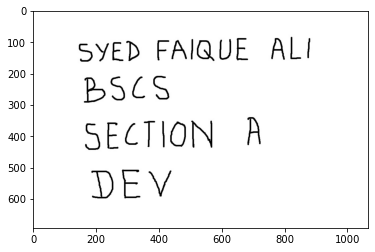

In [4]:
# Read image using opencv
img = cv2.imread(SAMPLE_IMAGE)

# Display image using matplotlib
plt.imshow(img)
plt.show()

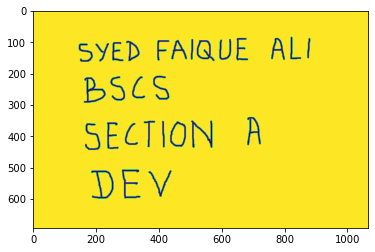

In [5]:
# convert the image to grayscale format
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

plt.imshow(img_gray)
plt.show()

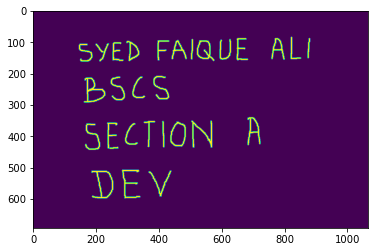

In [6]:
# apply thresholding
ret, thresh = cv2.threshold(img_gray, 150, 255, cv2.THRESH_OTSU|cv2.THRESH_BINARY_INV)

plt.imshow(thresh)
plt.show()

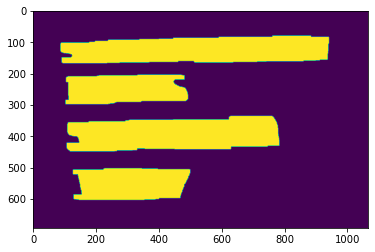

In [22]:
# Finding rows
rect_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (120,10))
dilation = cv2.dilate(thresh, rect_kernel, iterations=1)

plt.imshow(dilation)
plt.show()

### 1b. Find rows contours of the image

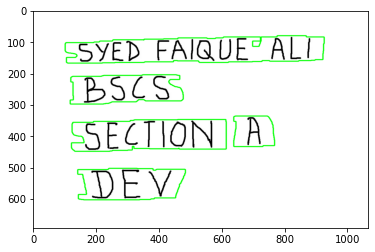

In [8]:
# detect the contours on the binary image using cv2.CHAIN_APPROX_NONE
contours, hierarchy = cv2.findContours(image=dilation, mode=cv2.RETR_EXTERNAL, method=cv2.CHAIN_APPROX_NONE)
                                     
# draw contours on the original image
image_copy = img.copy()
cv2.drawContours(image=image_copy, contours=contours, contourIdx=-1, color=(0, 255, 0), thickness=2, lineType=cv2.LINE_AA)
               
plt.imshow(image_copy)
plt.show()

In [9]:
len(contours)

5

### Contours Hierarchy

`RETR_EXTERNAL`: It retrieves only the outer contours.

`Hierarchy`: Returns array [Next, Previous, First_Child, Parent]

In [10]:
hierarchy.shape

(1, 5, 4)

In [11]:
hierarchy.shape[1]

5

In [12]:
hier = hierarchy[0][0]

In [13]:
next_contour, pre_contour, first_child, parent = hier #Extracting the desired contour hierarchy
print(f'Next Contour: {next_contour}')
print(f'Previous Contour: {pre_contour}')
print(f'First Child: {first_child}')
print(f'Parent Contour: {parent}')

Next Contour: 1
Previous Contour: -1
First Child: -1
Parent Contour: -1


In [14]:
#contours.reverse()

### 1c. Drawing bounding boxes on contours i.e rows

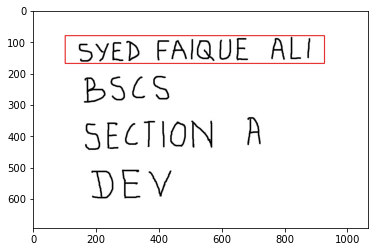

In [20]:
cnt = contours[4]
image_new_copy_2 = img.copy()

x,y,w,h = cv2.boundingRect(cnt)
plt.imshow(cv2.rectangle(image_new_copy_2, (x,y), (x+w,y+h), (225,0,0), 2))
plt.show()

In [ ]:
ARR_CROPPED_ROWS = []
draw_rectangle_on_img_contours_and_croppping_them(contours, thresh.copy(),ARR_CROPPED_ROWS)

In [ ]:
ARR_CROPPED_ROWS[2]

## Step2 : Finding columns(words) in a single line(row)

### 2a. Meshing all columns characters together to extract columns(words).

In [ ]:
# Display image using matplotlib
img = ARR_CROPPED_ROWS[2].convert('RGB')
img = np.array(img)
plt.imshow(img)
plt.show()

In [ ]:
# convert the image to grayscale format
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

plt.imshow(img_gray)
plt.show()

In [ ]:
# apply thresholding
ret, thresh = cv2.threshold(img_gray, 150, 255, cv2.THRESH_OTSU|cv2.THRESH_BINARY)

plt.imshow(thresh)
plt.show()

In [ ]:
# Finding columns(words)
rect_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (50,1))
dilation = cv2.dilate(thresh, rect_kernel, iterations=1)

plt.imshow(dilation)
plt.show()

### 2b. Find column contours of the image

In [ ]:
# detect the contours on the binary image using cv2.CHAIN_APPROX_NONE
contours, hierarchy = cv2.findContours(image=dilation, mode=cv2.RETR_EXTERNAL, method=cv2.CHAIN_APPROX_NONE)
                                     
# draw contours on the original image
image_copy = img.copy()
cv2.drawContours(image=image_copy, contours=contours, contourIdx=-1, color=(0, 255, 0), thickness=2, lineType=cv2.LINE_AA)
               
plt.imshow(image_copy)
plt.show()

In [ ]:
len(contours)

In [ ]:
contours.reverse()

### 2c. Drawing bounding boxes on contours i.e columns(words)

In [ ]:
cnt = contours[0]
image_new_copy_2 = img.copy()

x,y,w,h = cv2.boundingRect(cnt)
plt.imshow(cv2.rectangle(image_new_copy_2, (x,y), (x+w,y+h), (225,0,0), 2))
plt.show()

In [ ]:
ARR_CROPPED_WORDS = []
draw_rectangle_on_img_contours_and_croppping_them(contours, thresh.copy(),ARR_CROPPED_WORDS)

In [ ]:
ARR_CROPPED_WORDS[1]

## Step3 : Finding characters in a single word

In [ ]:
# Read image using opencv
img = ARR_CROPPED_WORDS[0].convert('RGB')
img = np.array(img)

# Display image using matplotlib
plt.imshow(img)
plt.show()

In [ ]:
# convert the image to grayscale format
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

plt.imshow(img_gray)
plt.show()

In [ ]:
# apply thresholding
ret, thresh = cv2.threshold(img_gray, 150, 255, cv2.THRESH_OTSU|cv2.THRESH_BINARY)

plt.imshow(thresh)
plt.show()

### 3b. Find Image contours

In [ ]:
# detect the contours on the binary image using cv2.CHAIN_APPROX_NONE
contours, hierarchy = cv2.findContours(image=thresh, mode=cv2.RETR_EXTERNAL, method=cv2.CHAIN_APPROX_NONE)
                                     
# draw contours on the original image
image_copy = img.copy()
cv2.drawContours(image=image_copy, contours=contours, contourIdx=-1, color=(0, 255, 0), thickness=2, lineType=cv2.LINE_AA)
               
plt.imshow(image_copy)
plt.show()

In [ ]:
len(contours)

In [ ]:
# Sort contours from left->Right
contours = sorted(contours, key=ret_x_cord_contour, reverse=False)

### 3c. Drawing boxes on contours

In [ ]:
cnt = contours[1]
image_new_copy_2 = img.copy()

x,y,w,h = cv2.boundingRect(cnt)
plt.imshow(cv2.rectangle(image_new_copy_2, (x,y), (x+w,y+h), (225,0,0), 2))
plt.show()

In [ ]:
ARR_CROPPED_CHARS = []
draw_rectangle_on_img_contours_and_croppping_them(contours, thresh.copy(),ARR_CROPPED_CHARS)

In [ ]:
ARR_CROPPED_CHARS[1]

In [ ]:
ARR_CROPPED_CHARS_NEW = []
for img in ARR_CROPPED_CHARS:
    img = np.array(img)
    img = cv2.bitwise_not(img)
    img = Image.fromarray(img)
    ARR_CROPPED_CHARS_NEW.append(img)

In [ ]:
ARR_CROPPED_CHARS_NEW[0]

In [ ]:
# ------------------------------------------------
# STEP 3.1: CONVERT CROPPED DIGITS TO 20X20
# ------------------------------------------------
arr_img_20x20 = resizing_cropped_img_to_20_by_20(ARR_CROPPED_CHARS_NEW)

# ------------------------------------------------
# STEP 3.2: CONVERT 20x20 TO 28X28 AND REVERSE IT
# ------------------------------------------------
arr_img_28x28 = add_borders_to_img(arr_img_20x20)

In [ ]:
arr_img_28x28[2]